* Amir Esmaeili, 50225893, s77aesma@uni-bonn.de
* Kiavash Jamshidi, 50151853, s19kjams@uni-bonn.de

In [1]:
!pip install transformers datasets torch torchvision
!pip install 'accelerate>={ACCELERATE_MIN_VERSION}'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 12.2 MB/s eta 0:00:00
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 7.3 MB/s eta 0:00:00
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 42.8 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 5.7 MB/s eta 0:00:000m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 11.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.3 MB/s eta 0:00:0031m54.9 MB/s eta 0:00:

## Task 1

In [38]:
import torch
from torch import Tensor
from typing import List
from pandas import read_csv
from collections import Counter
import string
from torch import nn

from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F

In [39]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
            self,
            sequence_length,
    ):
        self.sequence_length = sequence_length
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self) -> List[str]:
        """Returns a list of all words in the dataset.
        Make sure to strip punctuation and lowercase the words"""
        # Read the CSV file
        df = read_csv('reddit-cleanjokes.csv')

        # Convert jokes to lowercase and split into words
        # Assuming the jokes are in a column named 'joke' or similar
        # Adjust column name if needed
        all_words = []
        for joke in df['Joke']:
            # Convert to lowercase and split into words
            words = joke.lower().split()
            # Strip basic punctuation from words
            words = [word.strip('.,!?:;"\'()[]{}') for word in words]
            all_words.extend(words)

        return all_words

    def get_uniq_words(self) -> List[str]:
        """Returns a list, containing each unique word in the dataset once"""
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self) -> int:
        """Returns the number of `self.sequence_length` length word spans in the dataset"""
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index) -> Tuple[Tensor, Tensor]:
        """Returns a tuple of two torch.Tensors:
        an input sequence for the RNN/LSTM model and a target sequence.
        The tensors should be 1D and have length equal to self.sequence_length.
        Remember that the target should be shifted with respect to the input."""
        # Get the sequence at the current index
        sequence = self.words_indexes[index:index + self.sequence_length]
        # Get the target sequence (shifted by one position)
        target = self.words_indexes[index + 1:index + self.sequence_length + 1]

        return (
            torch.tensor(sequence),
            torch.tensor(target)
        )

In [3]:
dataset = Dataset(4)
dataset.load_words()

['what',
 'did',
 'the',
 'bartender',
 'say',
 'to',
 'the',
 'jumper',
 'cables',
 'you',
 'better',
 'not',
 'try',
 'to',
 'start',
 'anything',
 "don't",
 'you',
 'hate',
 'jokes',
 'about',
 'german',
 'sausage',
 "they're",
 'the',
 'wurst',
 'two',
 'artists',
 'had',
 'an',
 'art',
 'contest',
 'it',
 'ended',
 'in',
 'a',
 'draw',
 'why',
 'did',
 'the',
 'chicken',
 'cross',
 'the',
 'playground',
 'to',
 'get',
 'to',
 'the',
 'other',
 'slide',
 'what',
 'gun',
 'do',
 'you',
 'use',
 'to',
 'hunt',
 'a',
 'moose',
 'a',
 'moosecut',
 'if',
 'life',
 'gives',
 'you',
 'melons',
 'you',
 'might',
 'have',
 'dyslexia',
 'broken',
 'pencils',
 'are',
 'pointless',
 'what',
 'did',
 'one',
 'snowman',
 'say',
 'to',
 'the',
 'other',
 'snowman',
 'do',
 'you',
 'smell',
 'carrots',
 'how',
 'many',
 'hipsters',
 'does',
 'it',
 'take',
 'to',
 'change',
 'a',
 'lightbulb',
 "it's",
 'a',
 'really',
 'obscure',
 'number',
 "you've",
 'probably',
 'never',
 'heard',
 'of',
 'it'

**important**: I checked different sources and all, including torch document. They all used batch size for the shape of init_state. So I changed the template to match that.  
Links:
* https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* https://www.geeksforgeeks.org/implementing-recurrent-neural-networks-in-pytorch/
* https://github.com/sssingh/tv-script-generation-rnn/blob/master/notebooks/tv_script_generation.ipynb

In [89]:
class RNNModel(nn.Module):
    def __init__(self, dataset):
        super(RNNModel, self).__init__()
        self.hidden_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab, embedding_dim=self.embedding_dim)
        self.rnn = nn.RNN(input_size=self.embedding_dim, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, n_vocab)

    def init_state(self, batch_size: int) -> Tensor:
        """Returns the initial hidden state."""
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

    def forward(self, inputs: Tensor, prev_hidden_state: Tensor) -> (Tensor, Tensor):
        """Compute logits and next hidden state."""
        embeddings = self.embedding(inputs)
        rnn_out, hidden_state = self.rnn(embeddings, prev_hidden_state)
        logits = self.fc(rnn_out)
        return logits, hidden_state

In [90]:
model = RNNModel(dataset)

In [91]:
def count_params(model: nn.Module) -> Tuple[int, int]:
    # YOUR CODE HERE
    n_params = 0
    n_trainable_params = 0

    for param in model.parameters():
        n_params += param.numel()  # numel() returns total number of elements
        if param.requires_grad:
            n_trainable_params += param.numel()

    return n_params, n_trainable_params


total, trainable = count_params(model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable}")

Total parameters: 1343980
Trainable parameters: 1343980


In [96]:
def train_rnn(dataset, model, sequence_length, batch_size, max_epochs):
    model.train()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_list = []

    for epoch in range(max_epochs):
        total_loss = 0

        for batch, (x, y) in enumerate(dataloader):
            # Dynamically initialize the hidden state based on batch size
            state_h = model.init_state(batch_size=x.size(0))
            state_h = state_h.detach()  # Detach to prevent backpropagation through time

            optimizer.zero_grad()
            y_pred, state_h = model(x, state_h)
            loss = criterion(y_pred.transpose(1, 2), y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        loss_list.append(total_loss / len(dataloader))
        print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {total_loss / len(dataloader):.4f}")

    return loss_list

In [97]:
train_loss_rnn = train_rnn(dataset, model, 4, 256, 10)

Epoch 1/10, Loss: 6.1091
Epoch 2/10, Loss: 5.6440
Epoch 3/10, Loss: 5.3064
Epoch 4/10, Loss: 5.0092
Epoch 5/10, Loss: 4.7434
Epoch 6/10, Loss: 4.5082
Epoch 7/10, Loss: 4.2882
Epoch 8/10, Loss: 4.0888
Epoch 9/10, Loss: 3.9138
Epoch 10/10, Loss: 3.7506


In [98]:
def predict_rnn_argmax(dataset, model, text, next_words=100):
    model.eval()
    words = text.lower().split()
    state_h = model.init_state(1)

    for _ in range(next_words):
        x = torch.tensor([[dataset.word_to_index.get(w, 0) for w in words[-dataset.sequence_length:]]], dtype=torch.long)
        y_pred, state_h = model(x, state_h)
        last_word_logits = y_pred[0, -1]
        word_id = torch.argmax(last_word_logits).item()
        words.append(dataset.index_to_word[word_id])

    return words

def predict_rnn_softmax(dataset, model, text, next_words=100):
    model.eval()
    words = text.lower().split()
    state_h = model.init_state(1)

    for _ in range(next_words):
        x = torch.tensor([[dataset.word_to_index.get(w, 0) for w in words[-dataset.sequence_length:]]], dtype=torch.long)
        y_pred, state_h = model(x, state_h)
        last_word_logits = y_pred[0, -1]
        probabilities = F.softmax(last_word_logits, dim=0)
        word_id = torch.multinomial(probabilities, num_samples=1).item()
        words.append(dataset.index_to_word[word_id])

    return words

In [99]:
text = "Why don’t skeletons fight eachother?"

# Using predict_rnn_argmax
predicted_words_argmax = predict_rnn_argmax(dataset, model, text, next_words=10)
print("Predicted words using argmax:", predicted_words_argmax)

# Using predict_rnn_softmax
predicted_words_softmax = predict_rnn_softmax(dataset, model, text, next_words=10)
print("Predicted words using softmax:", predicted_words_softmax)

Predicted words using argmax: ['why', 'don’t', 'skeletons', 'fight', 'eachother?', 'fish', 'what', 'do', 'you', 'call', 'a', 'cow', 'with', 'no', 'legs']
Predicted words using softmax: ['why', 'don’t', 'skeletons', 'fight', 'eachother?', 'chech', 'deer', 'who', 'were', 'trained', 'in', 'wisconsin', 'our', 'ouch', 'what']


### LSTM

In [103]:
class LSTMModel(nn.Module):
    def __init__(self, dataset):
        super(LSTMModel, self).__init__()
        self.hidden_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab, embedding_dim=self.embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)

        return logits, state

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

In [104]:
def train_lstm(dataset, model, sequence_length, batch_size, max_epochs):
    model.train()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_list = []

    for epoch in range(max_epochs):
        total_loss = 0

        for batch, (x, y) in enumerate(dataloader):
            # Dynamically initialize the hidden state based on batch size
            state_h = model.init_state(batch_size=x.size(0))

            optimizer.zero_grad()
            y_pred, state_h = model(x, state_h)
            loss = criterion(y_pred.transpose(1, 2), y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        loss_list.append(total_loss / len(dataloader))
        print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {total_loss / len(dataloader):.4f}")

    return loss_list

In [105]:
model_lstm = LSTMModel(dataset)
train_loss_lstm = train_lstm(dataset, model_lstm, 4, 256, 10)

Epoch 1/10, Loss: 7.2146
Epoch 2/10, Loss: 6.6073
Epoch 3/10, Loss: 6.5386
Epoch 4/10, Loss: 6.3912
Epoch 5/10, Loss: 6.2242
Epoch 6/10, Loss: 6.0517
Epoch 7/10, Loss: 5.8840
Epoch 8/10, Loss: 5.7186
Epoch 9/10, Loss: 5.5492
Epoch 10/10, Loss: 5.3851


In [106]:
def predict_lstm_argmax(dataset, model, text, next_words=100):
    model.eval()
    words = text.lower().split()
    state_h = model.init_state(1)

    for _ in range(next_words):
        x = torch.tensor([[dataset.word_to_index.get(w, 0) for w in words[-dataset.sequence_length:]]], dtype=torch.long)
        y_pred, state_h = model(x, state_h)
        last_word_logits = y_pred[0, -1]
        word_id = torch.argmax(last_word_logits).item()
        words.append(dataset.index_to_word[word_id])

    return words

def predict_lstm_softmax(dataset, model, text, next_words=100):
    model.eval()
    words = text.lower().split()
    state_h = model.init_state(1)

    for _ in range(next_words):
        x = torch.tensor([[dataset.word_to_index.get(w, 0) for w in words[-dataset.sequence_length:]]], dtype=torch.long)
        y_pred, state_h = model(x, state_h)
        last_word_logits = y_pred[0, -1]
        probabilities = F.softmax(last_word_logits, dim=0)
        word_id = torch.multinomial(probabilities, num_samples=1).item()
        words.append(dataset.index_to_word[word_id])

    return words

In [107]:
text = "Why don’t skeletons fight eachother?"

# Using predict_lstm_argmax
predicted_words_argmax = predict_lstm_argmax(dataset, model_lstm, text, next_words=10)
print("Predicted words using argmax:", predicted_words_argmax)

# Using predict_lstm_softmax
predicted_words_softmax = predict_lstm_softmax(dataset, model_lstm, text, next_words=10)
print("Predicted words using softmax:", predicted_words_softmax)

Predicted words using argmax: ['why', 'don’t', 'skeletons', 'fight', 'eachother?', 'joke', 'a', 'cow', 'what', 'do', 'you', 'call', 'a', 'bar', 'what']
Predicted words using softmax: ['why', 'don’t', 'skeletons', 'fight', 'eachother?', 'skelleton', "it's", 'a', 'while', 'when', 'it', 'thought', 'to', 'make', 'to']


In [108]:
import matplotlib.pyplot as plt
import numpy as np


def plot_loss_comparison(rnn_loss, lstm_loss):
    """
    Create a detailed comparison plot of RNN and LSTM training losses
    """
    
    # Create figure and axis with specific size and style
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot epochs on x-axis
    epochs = np.arange(1, len(rnn_loss) + 1)
    
    # Top subplot - Combined losses
    ax1.plot(epochs, rnn_loss, 'b-', label='RNN Loss', linewidth=2, marker='o')
    ax1.plot(epochs, lstm_loss, 'r-', label='LSTM Loss', linewidth=2, marker='s')
    ax1.set_title('RNN vs LSTM Training Loss Comparison', pad=15, fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc='upper right')
    
    # Bottom subplot - Loss difference
    loss_diff = np.array(rnn_loss) - np.array(lstm_loss)
    ax2.bar(epochs, loss_diff, color='purple', alpha=0.6, label='RNN Loss - LSTM Loss')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_title('Loss Difference (RNN - LSTM)', pad=15, fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss Difference')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # Add summary statistics
    stats_text = f'Summary Statistics:\n' \
                 f'RNN  - Final Loss: {rnn_loss[-1]:.4f}, Min Loss: {min(rnn_loss):.4f}\n' \
                 f'LSTM - Final Loss: {lstm_loss[-1]:.4f}, Min Loss: {min(lstm_loss):.4f}'
    fig.text(0.1, 0.02, stats_text, fontsize=10, family='monospace')
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()

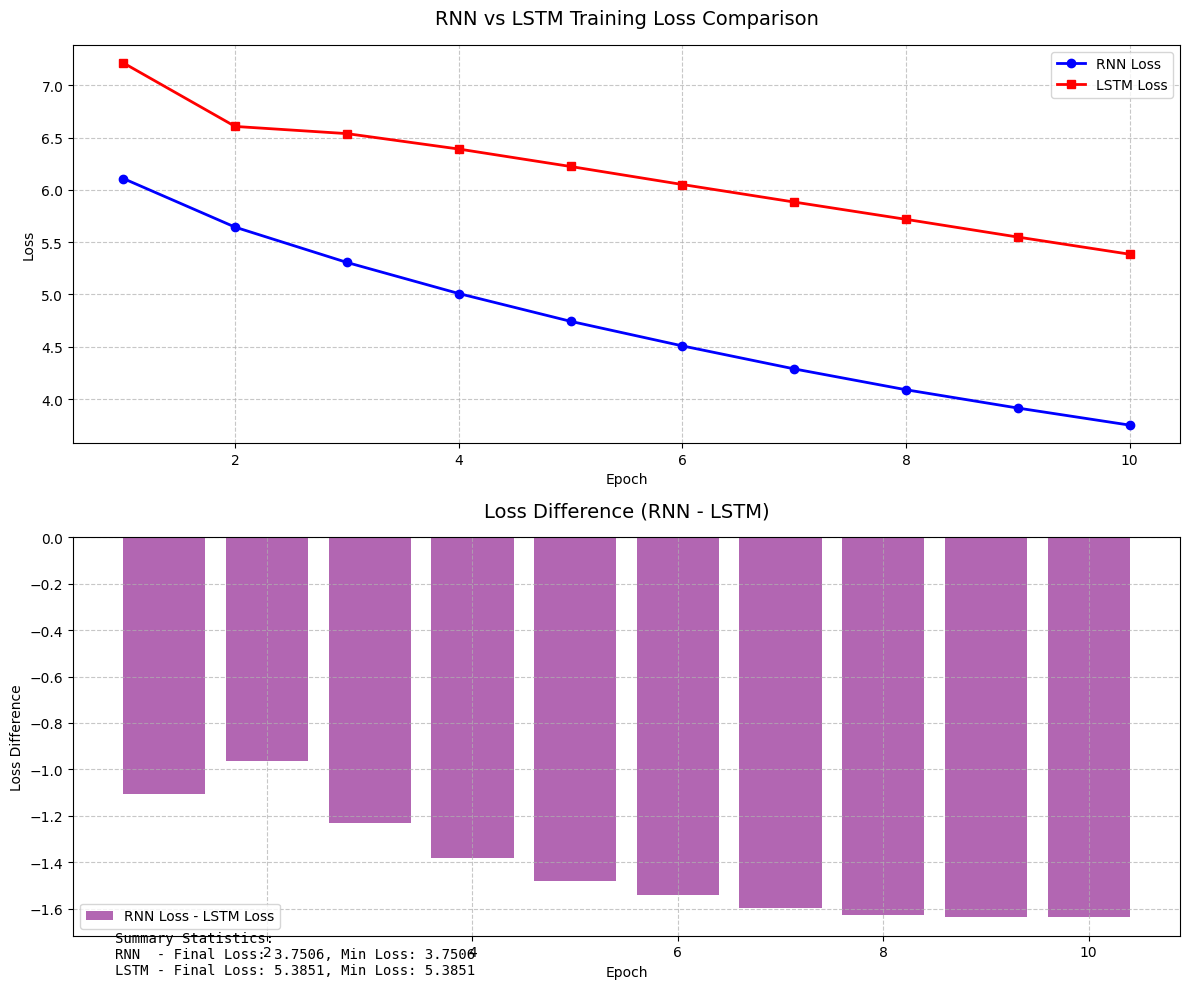

In [109]:
plot_loss_comparison(train_loss_rnn, train_loss_lstm)

### Key differences between RNN and LSTM architectures

* Memory Cell: LSTM has a more complex internal structure with a memory cell and three gates (input, forget, output), while RNN has a simple hidden state.
* Gradient Flow: LSTM is better at handling long-term dependencies because its architecture helps prevent vanishing gradients through the cell state.
* Parameter Count: LSTM has more parameters due to its additional gates, which can make it more powerful but also slower to train.
* State Management: LSTM maintains two states (hidden state and cell state) while RNN only has one hidden state.

### Limitations of both models

* Limited Context: Both models can only consider a fixed context window (sequence_length).
* Vocabulary Constraints: They can only generate words from the training vocabulary.
* Coherence: Generated text might lack long-term coherence and logical consistency.
* Training Data Dependency: Quality and diversity of generated text heavily depends on training data.

### Why RNN performed better (However, it was a short training period)
The RNN likely performed better primarily because the jokes dataset consists of short sequences with mostly local word dependencies, making the LSTM's complex architecture unnecessary overhead. The RNN's simpler structure was better matched to this specific task, while the LSTM's additional parameters and gates might have led to overfitting and more challenging training dynamics. This illustrates that simpler models can outperform more complex ones when the task doesn't require the additional capabilities.

## Task 2 ##

In [3]:

from datasets import load_dataset

dataset = load_dataset("sem_eval_2018_task_1", "subtask5.english")

print(dataset["validation"][-1])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sem_eval_2018_task_1.py:   0%|          | 0.00/6.29k [00:00<?, ?B/s]

The repository for sem_eval_2018_task_1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sem_eval_2018_task_1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/6838 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3259 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/886 [00:00<?, ? examples/s]

{'ID': '2018-En-03386', 'Tweet': 'I am really flattered and happy to hear those complements for my blog! You guys motivates me to write more for my blog. Thank you! sml 💞', 'anger': False, 'anticipation': False, 'disgust': False, 'fear': False, 'joy': True, 'love': False, 'optimism': True, 'pessimism': False, 'sadness': False, 'surprise': False, 'trust': False}


## Task 3 ##

In [4]:
from transformers import BertTokenizer
import torch


def tokenize_data(dataset):
    # Load the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # Define the tokenization function
    def preprocess(example):
        # Tokenize the text
        encoding = tokenizer(
            example["Tweet"],
            padding="max_length",  # Pad to max length
            truncation=True,  # Truncate if too long
            max_length=128,  # Define max token length
        )
        # Convert labels to a tensor of floats
        labels = [example[label] for label in dataset["train"].features.keys() if label not in ["ID", "Tweet"]]
        encoding["labels"] = torch.tensor(labels, dtype=torch.float)
        return encoding

    # Apply the tokenization function to the dataset
    encoded_dataset = dataset.map(preprocess, batched=False)

    # Set format to PyTorch
    encoded_dataset.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])

    return encoded_dataset


# Tokenize the dataset
encoded_dataset = tokenize_data(dataset)

# Print the keys of the last data point in the validation set
print(encoded_dataset["validation"][-1].keys())


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/6838 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Map:   0%|          | 0/886 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Task 4 ##

In [6]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of labels
num_labels = len(dataset["train"].features) - 2  # Exclude "ID" and "Tweet"

# Create id2label and label2id mappings
id2label = {i: label for i, label in
            enumerate([key for key in dataset["train"].features.keys() if key not in ["ID", "Tweet"]])}
label2id = {label: i for i, label in id2label.items()}

# Define the model and move it to the GPU (if available)
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification"
).to(device)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions
    preds = (preds > 0.5).astype(int)  # Convert logits to binary predictions

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro")
    accuracy = accuracy_score(labels, preds)

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    # Enable mixed precision if possible (this also speeds up training)
    fp16=True if torch.cuda.is_available() else False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.332500,0.316661,0.248307,0.647108,0.816643,0.535863
2,0.259300,0.302272,0.257336,0.662230,0.826298,0.552522
3,0.260200,0.301693,0.278781,0.680446,0.825198,0.578899


TrainOutput(global_step=2565, training_loss=0.29860036517212035, metrics={'train_runtime': 368.8189, 'train_samples_per_second': 55.621, 'train_steps_per_second': 6.955, 'total_flos': 1349474086052352.0, 'train_loss': 0.29860036517212035, 'epoch': 3.0})

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Extract tweets and labels
tweets = dataset["train"]["Tweet"]
labels = np.array([list(example.values())[2:] for example in dataset["train"]])  # Exclude "ID" and "Tweet"

# Split into train and validation sets
tweets_train, tweets_val, labels_train, labels_val = train_test_split(tweets, labels, test_size=0.2, random_state=42)

# TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(tweets_train)
X_val = vectorizer.transform(tweets_val)

# Logistic Regression with OneVsRest for multi-label classification
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, labels_train)

# Evaluate
predictions = clf.predict(X_val)
print(classification_report(labels_val, predictions, target_names=id2label.values()))


              precision    recall  f1-score   support

       anger       0.83      0.53      0.64       507
anticipation       0.50      0.01      0.02       200
     disgust       0.78      0.47      0.59       516
        fear       0.93      0.26      0.41       283
         joy       0.87      0.55      0.67       507
        love       0.82      0.10      0.18       136
    optimism       0.76      0.38      0.51       400
   pessimism       0.33      0.01      0.01       166
     sadness       0.82      0.27      0.41       424
    surprise       1.00      0.03      0.05        76
       trust       0.00      0.00      0.00        71

   micro avg       0.82      0.35      0.49      3286
   macro avg       0.69      0.24      0.32      3286
weighted avg       0.77      0.35      0.46      3286
 samples avg       0.55      0.37      0.42      3286



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_